<a href="https://colab.research.google.com/github/hugeinteger/GANs/blob/master/ConditionalStyleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

So first, let's clone the repo and move into it.

In [0]:
! git clone https://github.com/davidstap/stylegan.git condstylegan
import os
os.chdir("condstylegan")

fatal: destination path 'condstylegan' already exists and is not an empty directory.


Next, we need to import a few required libraries. You can pretty much leave this part alone, but be sure to run it.

In [0]:
import os
import pickle
import PIL.Image
import numpy as np
import dnnlib
import dnnlib.tflib as tflib

import matplotlib.pyplot as plt
%matplotlib inline

W0901 22:34:17.800725 140589049874304 deprecation_wrapper.py:119] From /content/condstylegan/dnnlib/tflib/tfutil.py:34: The name tf.Dimension is deprecated. Please use tf.compat.v1.Dimension instead.

W0901 22:34:17.801971 140589049874304 deprecation_wrapper.py:119] From /content/condstylegan/dnnlib/tflib/tfutil.py:74: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0901 22:34:17.806632 140589049874304 deprecation_wrapper.py:119] From /content/condstylegan/dnnlib/tflib/tfutil.py:128: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



Download coco dataset to my_datasets/coco_train_2017

In [0]:
!mkdir my_datasets
os.chdir("my_datasets")

#!wget http://images.cocodataset.org/zips/train2014.zip
#!unzip train2014.zip
#!mv train2014 coco_train_2014

!wget http://images.cocodataset.org/zips/test2014.zip
!unzip test2014.zip
!mv test2014 coco_test_2014

#!wget http://images.cocodataset.org/zips/val2014.zip
#!unzip val2014.zip
#!mv val2014 coco_val_2014
  
#!wget http://images.cocodataset.org/annotations/image_info_test2014.zip
#!unzip image_info_test2014.zip
#!mv annotations coco_image_info_test_2014

#!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
#!unzip annotations_trainval2014.zip
#!mv annotations coco_annotations_trainval_2014

#!mkdir coco
#!cp coco_train_2014/* ../coco
#!cp coco_test_2014/* coco
#!cp coco_val_2014/* coco

#os.chdir("../")

--2019-09-01 22:34:38--  http://images.cocodataset.org/zips/test2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.110.211
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.110.211|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6660437059 (6.2G) [application/zip]
Saving to: ‘test2014.zip’

test2014.zip        100%[===================>]   6.20G  20.1MB/s    in 5m 19s  

2019-09-01 22:39:58 (19.9 MB/s) - ‘test2014.zip’ saved [6660437059/6660437059]

Archive:  test2014.zip
   creating: test2014/
 extracting: test2014/COCO_test2014_000000503167.jpg  
 extracting: test2014/COCO_test2014_000000451615.jpg  
 extracting: test2014/COCO_test2014_000000531214.jpg  
 extracting: test2014/COCO_test2014_000000360107.jpg  
 extracting: test2014/COCO_test2014_000000056757.jpg  
 extracting: test2014/COCO_test2014_000000417580.jpg  
 extracting: test2014/COCO_test2014_000000273920.jpg  
 extracting: test2014/COCO_test2014_0000003433

In [0]:
# download full coco
#!mkdir coco
#os.chdir("coco")
#!wget http://www.cs.toronto.edu/~rkiros/datasets/coco.zip
#!unzip coco.zip
#!ls

Archive:  coco.zip
  inflating: coco_dev_caps.txt       
  inflating: coco_dev_ims.npy        
  inflating: coco_test_caps.txt      
  inflating: coco_test_ims.npy       
  inflating: coco_test.txt           
  inflating: coco_train_caps.txt     
  inflating: coco_train_ims.npy      
  inflating: coco_train.txt          
  inflating: coco_val.txt            
coco_dev_caps.txt   coco_test_ims.npy	 coco_train_ims.npy  coco.zip
coco_dev_ims.npy    coco_test.txt	 coco_train.txt
coco_test_caps.txt  coco_train_caps.txt  coco_val.txt


In [0]:
%%writefile code.py

# Copyright (c) 2019, NVIDIA CORPORATION. All rights reserved.
#
# This work is licensed under the Creative Commons Attribution-NonCommercial
# 4.0 International License. To view a copy of this license, visit
# http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
# Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

"""Tool for creating multi-resolution TFRecords datasets for StyleGAN and ProGAN."""

# pylint: disable=too-many-lines
import os
import sys
import glob
import argparse
import threading
import six.moves.queue as Queue # pylint: disable=import-error
import traceback
import numpy as np
import tensorflow as tf
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib

from training import dataset

#----------------------------------------------------------------------------

def error(msg):
    print('Error: ' + msg)
    exit(1)

#----------------------------------------------------------------------------

class TFRecordExporter:
    def __init__(self, tfrecord_dir, expected_images, print_progress=True, progress_interval=10):
        self.tfrecord_dir       = tfrecord_dir
        self.tfr_prefix         = os.path.join(self.tfrecord_dir, os.path.basename(self.tfrecord_dir))
        self.expected_images    = expected_images
        self.cur_images         = 0
        self.shape              = None
        self.resolution_log2    = None
        self.tfr_writers        = []
        self.print_progress     = print_progress
        self.progress_interval  = progress_interval

        if self.print_progress:
            print('Creating dataset "%s"' % tfrecord_dir)
        if not os.path.isdir(self.tfrecord_dir):
            os.makedirs(self.tfrecord_dir)
        assert os.path.isdir(self.tfrecord_dir)

    def close(self):
        if self.print_progress:
            print('%-40s\r' % 'Flushing data...', end='', flush=True)
        for tfr_writer in self.tfr_writers:
            tfr_writer.close()
        self.tfr_writers = []
        if self.print_progress:
            print('%-40s\r' % '', end='', flush=True)
            print('Added %d images.' % self.cur_images)

    def choose_shuffled_order(self): # Note: Images and labels must be added in shuffled order.
        order = np.arange(self.expected_images)
        np.random.RandomState(123).shuffle(order)
        return order

    def add_image(self, img):
        if self.print_progress and self.cur_images % self.progress_interval == 0:
            print('%d / %d\r' % (self.cur_images, self.expected_images), end='', flush=True)
        if self.shape is None:
            self.shape = img.shape
            self.resolution_log2 = int(np.log2(self.shape[1]))
            assert self.shape[0] in [1, 3]
            assert self.shape[1] == self.shape[2]
            assert self.shape[1] == 2**self.resolution_log2
            tfr_opt = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.NONE)
            for lod in range(self.resolution_log2 - 1):
                tfr_file = self.tfr_prefix + '-r%02d.tfrecords' % (self.resolution_log2 - lod)
                self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))
        assert img.shape == self.shape
        for lod, tfr_writer in enumerate(self.tfr_writers):
            if lod:
                img = img.astype(np.float32)
                img = (img[:, 0::2, 0::2] + img[:, 0::2, 1::2] + img[:, 1::2, 0::2] + img[:, 1::2, 1::2]) * 0.25
            quant = np.rint(img).clip(0, 255).astype(np.uint8)
            ex = tf.train.Example(features=tf.train.Features(feature={
                'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=quant.shape)),
                'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))}))
            tfr_writer.write(ex.SerializeToString())
        self.cur_images += 1

    def add_labels(self, labels):
        if self.print_progress:
            print('%-40s\r' % 'Saving labels...', end='', flush=True)
        assert labels.shape[0] == self.cur_images
        with open(self.tfr_prefix + '-rxx.labels', 'wb') as f:
            np.save(f, labels.astype(np.float32))

    def add_sentence_embedding(self, embeddings):
        # save as -rxx.labels for easy compatibility with rest of codebase.
        with open(self.tfr_prefix + '-rxx.labels', 'wb') as f:
            np.save(f, embeddings.astype(np.float32))

    def __enter__(self):
        return self

    def __exit__(self, *args):
        self.close()

#----------------------------------------------------------------------------

class ExceptionInfo(object):
    def __init__(self):
        self.value = sys.exc_info()[1]
        self.traceback = traceback.format_exc()

#----------------------------------------------------------------------------

class WorkerThread(threading.Thread):
    def __init__(self, task_queue):
        threading.Thread.__init__(self)
        self.task_queue = task_queue

    def run(self):
        while True:
            func, args, result_queue = self.task_queue.get()
            if func is None:
                break
            try:
                result = func(*args)
            except:
                result = ExceptionInfo()
            result_queue.put((result, args))

#----------------------------------------------------------------------------

class ThreadPool(object):
    def __init__(self, num_threads):
        assert num_threads >= 1
        self.task_queue = Queue.Queue()
        self.result_queues = dict()
        self.num_threads = num_threads
        for _idx in range(self.num_threads):
            thread = WorkerThread(self.task_queue)
            thread.daemon = True
            thread.start()

    def add_task(self, func, args=()):
        assert hasattr(func, '__call__') # must be a function
        if func not in self.result_queues:
            self.result_queues[func] = Queue.Queue()
        self.task_queue.put((func, args, self.result_queues[func]))

    def get_result(self, func): # returns (result, args)
        result, args = self.result_queues[func].get()
        if isinstance(result, ExceptionInfo):
            print('\n\nWorker thread caught an exception:\n' + result.traceback)
            raise result.value
        return result, args

    def finish(self):
        for _idx in range(self.num_threads):
            self.task_queue.put((None, (), None))

    def __enter__(self): # for 'with' statement
        return self

    def __exit__(self, *excinfo):
        self.finish()

    def process_items_concurrently(self, item_iterator, process_func=lambda x: x, pre_func=lambda x: x, post_func=lambda x: x, max_items_in_flight=None):
        if max_items_in_flight is None: max_items_in_flight = self.num_threads * 4
        assert max_items_in_flight >= 1
        results = []
        retire_idx = [0]

        def task_func(prepared, _idx):
            return process_func(prepared)

        def retire_result():
            processed, (_prepared, idx) = self.get_result(task_func)
            results[idx] = processed
            while retire_idx[0] < len(results) and results[retire_idx[0]] is not None:
                yield post_func(results[retire_idx[0]])
                results[retire_idx[0]] = None
                retire_idx[0] += 1

        for idx, item in enumerate(item_iterator):
            prepared = pre_func(item)
            results.append(None)
            self.add_task(func=task_func, args=(prepared, idx))
            while retire_idx[0] < idx - max_items_in_flight + 2:
                for res in retire_result(): yield res
        while retire_idx[0] < len(results):
            for res in retire_result(): yield res

#----------------------------------------------------------------------------

def display(tfrecord_dir):
    print('Loading dataset "%s"' % tfrecord_dir)
    tflib.init_tf({'gpu_options.allow_growth': True})
    dset = dataset.TFRecordDataset(tfrecord_dir, max_label_size='full', repeat=False, shuffle_mb=0)
    tflib.init_uninitialized_vars()
    import cv2  # pip install opencv-python

    idx = 0
    while True:
        try:
            images, labels = dset.get_minibatch_np(1)
        except tf.errors.OutOfRangeError:
            break
        if idx == 0:
            print('Displaying images')
            cv2.namedWindow('dataset_tool')
            print('Press SPACE or ENTER to advance, ESC to exit')
        print('\nidx = %-8d\nlabel = %s' % (idx, labels[0].tolist()))
        cv2.imshow('dataset_tool', images[0].transpose(1, 2, 0)[:, :, ::-1]) # CHW => HWC, RGB => BGR
        idx += 1
        if cv2.waitKey() == 27:
            break
    print('\nDisplayed %d images.' % idx)

#----------------------------------------------------------------------------

def extract(tfrecord_dir, output_dir):
    print('Loading dataset "%s"' % tfrecord_dir)
    tflib.init_tf({'gpu_options.allow_growth': True})
    dset = dataset.TFRecordDataset(tfrecord_dir, max_label_size=0, repeat=False, shuffle_mb=0)
    tflib.init_uninitialized_vars()

    print('Extracting images to "%s"' % output_dir)
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    idx = 0
    while True:
        if idx % 10 == 0:
            print('%d\r' % idx, end='', flush=True)
        try:
            images, _labels = dset.get_minibatch_np(1)
        except tf.errors.OutOfRangeError:
            break
        if images.shape[1] == 1:
            img = PIL.Image.fromarray(images[0][0], 'L')
        else:
            img = PIL.Image.fromarray(images[0].transpose(1, 2, 0), 'RGB')
        img.save(os.path.join(output_dir, 'img%08d.png' % idx))
        idx += 1
    print('Extracted %d images.' % idx)

#----------------------------------------------------------------------------

def compare(tfrecord_dir_a, tfrecord_dir_b, ignore_labels):
    max_label_size = 0 if ignore_labels else 'full'
    print('Loading dataset "%s"' % tfrecord_dir_a)
    tflib.init_tf({'gpu_options.allow_growth': True})
    dset_a = dataset.TFRecordDataset(tfrecord_dir_a, max_label_size=max_label_size, repeat=False, shuffle_mb=0)
    print('Loading dataset "%s"' % tfrecord_dir_b)
    dset_b = dataset.TFRecordDataset(tfrecord_dir_b, max_label_size=max_label_size, repeat=False, shuffle_mb=0)
    tflib.init_uninitialized_vars()

    print('Comparing datasets')
    idx = 0
    identical_images = 0
    identical_labels = 0
    while True:
        if idx % 100 == 0:
            print('%d\r' % idx, end='', flush=True)
        try:
            images_a, labels_a = dset_a.get_minibatch_np(1)
        except tf.errors.OutOfRangeError:
            images_a, labels_a = None, None
        try:
            images_b, labels_b = dset_b.get_minibatch_np(1)
        except tf.errors.OutOfRangeError:
            images_b, labels_b = None, None
        if images_a is None or images_b is None:
            if images_a is not None or images_b is not None:
                print('Datasets contain different number of images')
            break
        if images_a.shape == images_b.shape and np.all(images_a == images_b):
            identical_images += 1
        else:
            print('Image %d is different' % idx)
        if labels_a.shape == labels_b.shape and np.all(labels_a == labels_b):
            identical_labels += 1
        else:
            print('Label %d is different' % idx)
        idx += 1
    print('Identical images: %d / %d' % (identical_images, idx))
    if not ignore_labels:
        print('Identical labels: %d / %d' % (identical_labels, idx))

#----------------------------------------------------------------------------

def create_mnist(tfrecord_dir, mnist_dir):
    print('Loading MNIST from "%s"' % mnist_dir)
    import gzip
    with gzip.open(os.path.join(mnist_dir, 'train-images-idx3-ubyte.gz'), 'rb') as file:
        images = np.frombuffer(file.read(), np.uint8, offset=16)
    with gzip.open(os.path.join(mnist_dir, 'train-labels-idx1-ubyte.gz'), 'rb') as file:
        labels = np.frombuffer(file.read(), np.uint8, offset=8)
    images = images.reshape(-1, 1, 28, 28)
    images = np.pad(images, [(0,0), (0,0), (2,2), (2,2)], 'constant', constant_values=0)
    assert images.shape == (60000, 1, 32, 32) and images.dtype == np.uint8
    assert labels.shape == (60000,) and labels.dtype == np.uint8
    assert np.min(images) == 0 and np.max(images) == 255
    assert np.min(labels) == 0 and np.max(labels) == 9
    onehot = np.zeros((labels.size, np.max(labels) + 1), dtype=np.float32)
    onehot[np.arange(labels.size), labels] = 1.0

    with TFRecordExporter(tfrecord_dir, images.shape[0]) as tfr:
        order = tfr.choose_shuffled_order()
        for idx in range(order.size):
            tfr.add_image(images[order[idx]])
        tfr.add_labels(onehot[order])

#----------------------------------------------------------------------------

def create_mnistrgb(tfrecord_dir, mnist_dir, num_images=1000000, random_seed=123):
    print('Loading MNIST from "%s"' % mnist_dir)
    import gzip
    with gzip.open(os.path.join(mnist_dir, 'train-images-idx3-ubyte.gz'), 'rb') as file:
        images = np.frombuffer(file.read(), np.uint8, offset=16)
    images = images.reshape(-1, 28, 28)
    images = np.pad(images, [(0,0), (2,2), (2,2)], 'constant', constant_values=0)
    assert images.shape == (60000, 32, 32) and images.dtype == np.uint8
    assert np.min(images) == 0 and np.max(images) == 255

    with TFRecordExporter(tfrecord_dir, num_images) as tfr:
        rnd = np.random.RandomState(random_seed)
        for _idx in range(num_images):
            tfr.add_image(images[rnd.randint(images.shape[0], size=3)])

#----------------------------------------------------------------------------

def create_cifar10(tfrecord_dir, cifar10_dir):
    print('Loading CIFAR-10 from "%s"' % cifar10_dir)
    import pickle
    images = []
    labels = []
    for batch in range(1, 6):
        with open(os.path.join(cifar10_dir, 'data_batch_%d' % batch), 'rb') as file:
            data = pickle.load(file, encoding='latin1')
        images.append(data['data'].reshape(-1, 3, 32, 32))
        labels.append(data['labels'])
    images = np.concatenate(images)
    labels = np.concatenate(labels)
    assert images.shape == (50000, 3, 32, 32) and images.dtype == np.uint8
    assert labels.shape == (50000,) and labels.dtype == np.int32
    assert np.min(images) == 0 and np.max(images) == 255
    assert np.min(labels) == 0 and np.max(labels) == 9
    onehot = np.zeros((labels.size, np.max(labels) + 1), dtype=np.float32)
    onehot[np.arange(labels.size), labels] = 1.0

    with TFRecordExporter(tfrecord_dir, images.shape[0]) as tfr:
        order = tfr.choose_shuffled_order()
        for idx in range(order.size):
            tfr.add_image(images[order[idx]])
        tfr.add_labels(onehot[order])

#----------------------------------------------------------------------------

def create_cifar100(tfrecord_dir, cifar100_dir):
    print('Loading CIFAR-100 from "%s"' % cifar100_dir)
    import pickle
    with open(os.path.join(cifar100_dir, 'train'), 'rb') as file:
        data = pickle.load(file, encoding='latin1')
    images = data['data'].reshape(-1, 3, 32, 32)
    labels = np.array(data['fine_labels'])
    assert images.shape == (50000, 3, 32, 32) and images.dtype == np.uint8
    assert labels.shape == (50000,) and labels.dtype == np.int32
    assert np.min(images) == 0 and np.max(images) == 255
    assert np.min(labels) == 0 and np.max(labels) == 99
    onehot = np.zeros((labels.size, np.max(labels) + 1), dtype=np.float32)
    onehot[np.arange(labels.size), labels] = 1.0

    with TFRecordExporter(tfrecord_dir, images.shape[0]) as tfr:
        order = tfr.choose_shuffled_order()
        for idx in range(order.size):
            tfr.add_image(images[order[idx]])
        tfr.add_labels(onehot[order])

#----------------------------------------------------------------------------

def create_svhn(tfrecord_dir, svhn_dir):
    print('Loading SVHN from "%s"' % svhn_dir)
    import pickle
    images = []
    labels = []
    for batch in range(1, 4):
        with open(os.path.join(svhn_dir, 'train_%d.pkl' % batch), 'rb') as file:
            data = pickle.load(file, encoding='latin1')
        images.append(data[0])
        labels.append(data[1])
    images = np.concatenate(images)
    labels = np.concatenate(labels)
    assert images.shape == (73257, 3, 32, 32) and images.dtype == np.uint8
    assert labels.shape == (73257,) and labels.dtype == np.uint8
    assert np.min(images) == 0 and np.max(images) == 255
    assert np.min(labels) == 0 and np.max(labels) == 9
    onehot = np.zeros((labels.size, np.max(labels) + 1), dtype=np.float32)
    onehot[np.arange(labels.size), labels] = 1.0

    with TFRecordExporter(tfrecord_dir, images.shape[0]) as tfr:
        order = tfr.choose_shuffled_order()
        for idx in range(order.size):
            tfr.add_image(images[order[idx]])
        tfr.add_labels(onehot[order])

#----------------------------------------------------------------------------

def create_lsun(tfrecord_dir, lmdb_dir, resolution=256, max_images=None):
    print('Loading LSUN dataset from "%s"' % lmdb_dir)
    import lmdb # pip install lmdb # pylint: disable=import-error
    import cv2 # pip install opencv-python
    import io
    with lmdb.open(lmdb_dir, readonly=True).begin(write=False) as txn:
        total_images = txn.stat()['entries'] # pylint: disable=no-value-for-parameter
        if max_images is None:
            max_images = total_images
        with TFRecordExporter(tfrecord_dir, max_images) as tfr:
            for _idx, (_key, value) in enumerate(txn.cursor()):
                try:
                    try:
                        img = cv2.imdecode(np.fromstring(value, dtype=np.uint8), 1)
                        if img is None:
                            raise IOError('cv2.imdecode failed')
                        img = img[:, :, ::-1] # BGR => RGB
                    except IOError:
                        img = np.asarray(PIL.Image.open(io.BytesIO(value)))
                    crop = np.min(img.shape[:2])
                    img = img[(img.shape[0] - crop) // 2 : (img.shape[0] + crop) // 2, (img.shape[1] - crop) // 2 : (img.shape[1] + crop) // 2]
                    img = PIL.Image.fromarray(img, 'RGB')
                    img = img.resize((resolution, resolution), PIL.Image.ANTIALIAS)
                    img = np.asarray(img)
                    img = img.transpose([2, 0, 1]) # HWC => CHW
                    tfr.add_image(img)
                except:
                    print(sys.exc_info()[1])
                if tfr.cur_images == max_images:
                    break

#----------------------------------------------------------------------------

def create_lsun_wide(tfrecord_dir, lmdb_dir, width=512, height=384, max_images=None):
    assert width == 2 ** int(np.round(np.log2(width)))
    assert height <= width
    print('Loading LSUN dataset from "%s"' % lmdb_dir)
    import lmdb # pip install lmdb # pylint: disable=import-error
    import cv2 # pip install opencv-python
    import io
    with lmdb.open(lmdb_dir, readonly=True).begin(write=False) as txn:
        total_images = txn.stat()['entries'] # pylint: disable=no-value-for-parameter
        if max_images is None:
            max_images = total_images
        with TFRecordExporter(tfrecord_dir, max_images, print_progress=False) as tfr:
            for idx, (_key, value) in enumerate(txn.cursor()):
                try:
                    try:
                        img = cv2.imdecode(np.fromstring(value, dtype=np.uint8), 1)
                        if img is None:
                            raise IOError('cv2.imdecode failed')
                        img = img[:, :, ::-1] # BGR => RGB
                    except IOError:
                        img = np.asarray(PIL.Image.open(io.BytesIO(value)))

                    ch = int(np.round(width * img.shape[0] / img.shape[1]))
                    if img.shape[1] < width or ch < height:
                        continue

                    img = img[(img.shape[0] - ch) // 2 : (img.shape[0] + ch) // 2]
                    img = PIL.Image.fromarray(img, 'RGB')
                    img = img.resize((width, height), PIL.Image.ANTIALIAS)
                    img = np.asarray(img)
                    img = img.transpose([2, 0, 1]) # HWC => CHW

                    canvas = np.zeros([3, width, width], dtype=np.uint8)
                    canvas[:, (width - height) // 2 : (width + height) // 2] = img
                    tfr.add_image(canvas)
                    print('\r%d / %d => %d ' % (idx + 1, total_images, tfr.cur_images), end='')

                except:
                    print(sys.exc_info()[1])
                if tfr.cur_images == max_images:
                    break
    print()

#----------------------------------------------------------------------------

def create_celeba(tfrecord_dir, celeba_dir, cx=89, cy=121):
    print('Loading CelebA from "%s"' % celeba_dir)
    glob_pattern = os.path.join(celeba_dir, 'img_align_celeba_png', '*.png')
    image_filenames = sorted(glob.glob(glob_pattern))
    expected_images = 202599
    if len(image_filenames) != expected_images:
        error('Expected to find %d images' % expected_images)

    with TFRecordExporter(tfrecord_dir, len(image_filenames)) as tfr:
        order = tfr.choose_shuffled_order()
        for idx in range(order.size):
            img = np.asarray(PIL.Image.open(image_filenames[order[idx]]))
            assert img.shape == (218, 178, 3)
            img = img[cy - 64 : cy + 64, cx - 64 : cx + 64]
            img = img.transpose(2, 0, 1) # HWC => CHW
            tfr.add_image(img)

#----------------------------------------------------------------------------

def create_celebaHQ(tfrecord_dir, celeba_dir, delta_dir, num_threads=4, num_tasks=100, conditioning='none'):
    print('Loading CelebA from "%s"' % celeba_dir)
    expected_images = 202599

    if len(glob.glob(os.path.join(celeba_dir, 'Img/img_celeba', '*.jpg'))) != expected_images:
        error('Expected to find %d images' % expected_images)

    with open(os.path.join(celeba_dir, 'Anno', 'list_landmarks_celeba.txt'), 'rt') as file:
        landmarks = [[float(value) for value in line.split()[1:]] for line in file.readlines()[2:]]
        landmarks = np.float32(landmarks).reshape(-1, 5, 2)

    if conditioning == 'binary':
        print('Loading binary attributes')
        with open(os.path.join(celeba_dir, 'Anno', 'list_attr_celeba.txt'), 'rt') as f:
            # Load binary attributes
            attributes = np.array([[float(x) if float(x) == 1.0 else 0.0 for x in l.split()[1:]] for l in f.readlines()[2:]], dtype=np.float32)

    elif conditioning == 'textual':
        print('Loading textual descriptions')
            # Load textual descriptions
            # TODO: how to handle multiple descriptions???
        raise NotImplementedError

    print('Loading CelebA-HQ deltas from "%s"' % delta_dir)
    import scipy.ndimage
    import hashlib
    import bz2
    import zipfile
    import base64
    import cryptography.hazmat.primitives.hashes
    import cryptography.hazmat.backends
    import cryptography.hazmat.primitives.kdf.pbkdf2
    import cryptography.fernet
    expected_zips = 30

    if len(glob.glob(os.path.join(delta_dir, 'delta*.zip'))) != expected_zips:
        error('Expected to find %d zips' % expected_zips)

    with open(os.path.join(delta_dir, 'image_list.txt'), 'rt') as file:
        lines = [line.split() for line in file]
        fields = dict()
        for idx, field in enumerate(lines[0]):
            type = int if field.endswith('idx') else str
            fields[field] = [type(line[idx]) for line in lines[1:]]
    indices = np.array(fields['idx'])

    # Must use pillow version 3.1.1 for everything to work correctly.
    if getattr(PIL, 'PILLOW_VERSION', '') != '3.1.1':
        error('create_celebahq requires pillow version 3.1.1') # conda install pillow=3.1.1

    # Must use libjpeg version 8d for everything to work correctly.
    img = np.array(PIL.Image.open(os.path.join(celeba_dir, 'Img/img_celeba', '000001.jpg')))
    md5 = hashlib.md5()
    md5.update(img.tobytes())
    if md5.hexdigest() != '9cad8178d6cb0196b36f7b34bc5eb6d3':
        error('create_celebahq requires libjpeg version 8d') # conda install jpeg=8d

    def rot90(v):
        return np.array([-v[1], v[0]])

    def process_func(idx):
        # Load original image.
        orig_idx = fields['orig_idx'][idx]
        orig_file = fields['orig_file'][idx]
        orig_path = os.path.join(celeba_dir, 'img_celeba', orig_file)
        img = PIL.Image.open(orig_path)

        # Choose oriented crop rectangle.
        lm = landmarks[orig_idx]
        eye_avg = (lm[0] + lm[1]) * 0.5 + 0.5
        mouth_avg = (lm[3] + lm[4]) * 0.5 + 0.5
        eye_to_eye = lm[1] - lm[0]
        eye_to_mouth = mouth_avg - eye_avg
        x = eye_to_eye - rot90(eye_to_mouth)
        x /= np.hypot(*x)
        x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
        y = rot90(x)
        c = eye_avg + eye_to_mouth * 0.1
        quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
        zoom = 1024 / (np.hypot(*x) * 2)

        # Shrink.
        shrink = int(np.floor(0.5 / zoom))
        if shrink > 1:
            size = (int(np.round(float(img.size[0]) / shrink)), int(np.round(float(img.size[1]) / shrink)))
            img = img.resize(size, PIL.Image.ANTIALIAS)
            quad /= shrink
            zoom *= shrink

        # Crop.
        border = max(int(np.round(1024 * 0.1 / zoom)), 3)
        crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
        crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]), min(crop[3] + border, img.size[1]))
        if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
            img = img.crop(crop)
            quad -= crop[0:2]

        # Simulate super-resolution.
        superres = int(np.exp2(np.ceil(np.log2(zoom))))
        if superres > 1:
            img = img.resize((img.size[0] * superres, img.size[1] * superres), PIL.Image.ANTIALIAS)
            quad *= superres
            zoom /= superres

        # Pad.
        pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
        pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
        if max(pad) > border - 4:
            pad = np.maximum(pad, int(np.round(1024 * 0.3 / zoom)))
            img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
            h, w, _ = img.shape
            y, x, _ = np.mgrid[:h, :w, :1]
            mask = 1.0 - np.minimum(np.minimum(np.float32(x) / pad[0], np.float32(y) / pad[1]), np.minimum(np.float32(w-1-x) / pad[2], np.float32(h-1-y) / pad[3]))
            blur = 1024 * 0.02 / zoom
            img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
            img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
            img = PIL.Image.fromarray(np.uint8(np.clip(np.round(img), 0, 255)), 'RGB')
            quad += pad[0:2]

        # Transform.
        img = img.transform((4096, 4096), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
        img = img.resize((1024, 1024), PIL.Image.ANTIALIAS)
        img = np.asarray(img).transpose(2, 0, 1)

        # Verify MD5.
        md5 = hashlib.md5()
        md5.update(img.tobytes())
        assert md5.hexdigest() == fields['proc_md5'][idx]

        # Load delta image and original JPG.
        with zipfile.ZipFile(os.path.join(delta_dir, 'deltas%05d.zip' % (idx - idx % 1000)), 'r') as zip:
            delta_bytes = zip.read('delta%05d.dat' % idx)
        with open(orig_path, 'rb') as file:
            orig_bytes = file.read()

        # Decrypt delta image, using original JPG data as decryption key.
        algorithm = cryptography.hazmat.primitives.hashes.SHA256()
        backend = cryptography.hazmat.backends.default_backend()
        salt = bytes(orig_file, 'ascii')
        kdf = cryptography.hazmat.primitives.kdf.pbkdf2.PBKDF2HMAC(algorithm=algorithm, length=32, salt=salt, iterations=100000, backend=backend)
        key = base64.urlsafe_b64encode(kdf.derive(orig_bytes))
        delta = np.frombuffer(bz2.decompress(cryptography.fernet.Fernet(key).decrypt(delta_bytes)), dtype=np.uint8).reshape(3, 1024, 1024)

        # Apply delta image.
        img = img + delta

        # Verify MD5.
        md5 = hashlib.md5()
        md5.update(img.tobytes())
        assert md5.hexdigest() == fields['final_md5'][idx]
        return img


    print('Saving')
    quit()


    with TFRecordExporter(tfrecord_dir, indices.size) as tfr:
        order = tfr.choose_shuffled_order()
        with ThreadPool(num_threads) as pool:
            for img in pool.process_items_concurrently(indices[order].tolist(), process_func=process_func, max_items_in_flight=num_tasks):
                tfr.add_image(img)

            if conditioning == 'binary':
                tfr.add_labels(attributes[order])

            elif conditioning == 'textual':
                tfr.add_text_description()

    # TODO: test (i.e., load some images and check their attributes. Does it match?)









#----------------------------------------------------------------------------

def create_CUB(tfrecord_dir, CUB_dir):
    # Include tags and features (?)
    raise NotImplementedError


#----------------------------------------------------------------------------

def create_coco(tfrecord_dir, coco_dir, res=256, type='test'):
    import json
    import pickle

    tfrecord_dir = tfrecord_dir+'_{}'.format(type)
    # annotations = json.load(open(os.path.join(coco_dir, 'annotations/instances_train2014.json')))

    #filenames = np.load(os.path.join(coco_dir, '{}_filenames.npy'.format(type)))
    filenames = np.loadtxt(os.path.join(coco_dir, 'coco_test.txt'))
    embeddings = np.loadtxt(os.path.join(coco_dir, 'coco_test_caps.txt'))
    #embeddings = np.load(os.path.join(coco_dir, '{}_caption_features.npy'.format(type)))

    fns = []

    assert len(filenames) == len(embeddings)

    with TFRecordExporter(tfrecord_dir, len(embeddings)) as tfr:
        for i, fn in enumerate(filenames):

            # img = PIL.Image.open(os.path.join(coco_dir,'{}2014'.format(type),filenames[i][0]))
            # img = np.asarray(img.resize((res, res)))
            #
            # channels = img.shape[2] if img.ndim == 3 else 1
            #
            # if channels == 1:
            #     new_img = np.zeros((3, img.shape[0], img.shape[1]))
            #     new_img[0], new_img[1], new_img[2] = img, img, img
            #     img = new_img
            #
            # else:
            #     img = img.transpose([2, 0, 1]) # HWC => CHW

            # tfr.add_image(img)

            # Save filenames (can be used with index)
            fns.append(fn[0][fn[0].rindex('/')+1:])

        # Add all embeddings
        tfr.add_sentence_embedding(embeddings.astype(np.float32))
        np.save(open('fns.npy', 'wb'), fns)



#----------------------------------------------------------------------------


def create_from_images(tfrecord_dir, image_dir, shuffle):
    print('Loading images from "%s"' % image_dir)
    image_filenames = sorted(glob.glob(os.path.join(image_dir, '*')))
    if len(image_filenames) == 0:
        error('No input images found')

    img = np.asarray(PIL.Image.open(image_filenames[0]))
    resolution = img.shape[0]
    channels = img.shape[2] if img.ndim == 3 else 1
    if img.shape[1] != resolution:
        error('Input images must have the same width and height')
    if resolution != 2 ** int(np.floor(np.log2(resolution))):
        error('Input image resolution must be a power-of-two')
    if channels not in [1, 3]:
        error('Input images must be stored as RGB or grayscale')

    with TFRecordExporter(tfrecord_dir, len(image_filenames)) as tfr:
        order = tfr.choose_shuffled_order() if shuffle else np.arange(len(image_filenames))
        for idx in range(order.size):
            img = np.asarray(PIL.Image.open(image_filenames[order[idx]]))
            if channels == 1:
                img = img[np.newaxis, :, :] # HW => CHW
            else:
                img = img.transpose([2, 0, 1]) # HWC => CHW
            tfr.add_image(img)

#----------------------------------------------------------------------------

def create_from_hdf5(tfrecord_dir, hdf5_filename, shuffle):
    print('Loading HDF5 archive from "%s"' % hdf5_filename)
    import h5py # conda install h5py
    with h5py.File(hdf5_filename, 'r') as hdf5_file:
        hdf5_data = max([value for key, value in hdf5_file.items() if key.startswith('data')], key=lambda lod: lod.shape[3])
        with TFRecordExporter(tfrecord_dir, hdf5_data.shape[0]) as tfr:
            order = tfr.choose_shuffled_order() if shuffle else np.arange(hdf5_data.shape[0])
            for idx in range(order.size):
                tfr.add_image(hdf5_data[order[idx]])
            npy_filename = os.path.splitext(hdf5_filename)[0] + '-labels.npy'
            if os.path.isfile(npy_filename):
                tfr.add_labels(np.load(npy_filename)[order])

#----------------------------------------------------------------------------

def execute_cmdline(argv):
    prog = argv[0]
    parser = argparse.ArgumentParser(
        prog        = prog,
        description = 'Tool for creating multi-resolution TFRecords datasets for StyleGAN and ProGAN.',
        epilog      = 'Type "%s <command> -h" for more information.' % prog)

    subparsers = parser.add_subparsers(dest='command')
    subparsers.required = True
    def add_command(cmd, desc, example=None):
        epilog = 'Example: %s %s' % (prog, example) if example is not None else None
        return subparsers.add_parser(cmd, description=desc, help=desc, epilog=epilog)

    p = add_command(    'display',          'Display images in dataset.',
                                            'display datasets/mnist')
    p.add_argument(     'tfrecord_dir',     help='Directory containing dataset')

    p = add_command(    'extract',          'Extract images from dataset.',
                                            'extract datasets/mnist mnist-images')
    p.add_argument(     'tfrecord_dir',     help='Directory containing dataset')
    p.add_argument(     'output_dir',       help='Directory to extract the images into')

    p = add_command(    'compare',          'Compare two datasets.',
                                            'compare datasets/mydataset datasets/mnist')
    p.add_argument(     'tfrecord_dir_a',   help='Directory containing first dataset')
    p.add_argument(     'tfrecord_dir_b',   help='Directory containing second dataset')
    p.add_argument(     '--ignore_labels',  help='Ignore labels (default: 0)', type=int, default=0)

    p = add_command(    'create_mnist',     'Create dataset for MNIST.',
                                            'create_mnist datasets/mnist ~/downloads/mnist')
    p.add_argument(     'tfrecord_dir',     help='New dataset directory to be created')
    p.add_argument(     'mnist_dir',        help='Directory containing MNIST')

    p = add_command(    'create_mnistrgb',  'Create dataset for MNIST-RGB.',
                                            'create_mnistrgb datasets/mnistrgb ~/downloads/mnist')
    p.add_argument(     'tfrecord_dir',     help='New dataset directory to be created')
    p.add_argument(     'mnist_dir',        help='Directory containing MNIST')
    p.add_argument(     '--num_images',     help='Number of composite images to create (default: 1000000)', type=int, default=1000000)
    p.add_argument(     '--random_seed',    help='Random seed (default: 123)', type=int, default=123)

    p = add_command(    'create_cifar10',   'Create dataset for CIFAR-10.',
                                            'create_cifar10 datasets/cifar10 ~/downloads/cifar10')
    p.add_argument(     'tfrecord_dir',     help='New dataset directory to be created')
    p.add_argument(     'cifar10_dir',      help='Directory containing CIFAR-10')

    p = add_command(    'create_cifar100',  'Create dataset for CIFAR-100.',
                                            'create_cifar100 datasets/cifar100 ~/downloads/cifar100')
    p.add_argument(     'tfrecord_dir',     help='New dataset directory to be created')
    p.add_argument(     'cifar100_dir',     help='Directory containing CIFAR-100')

    p = add_command(    'create_svhn',      'Create dataset for SVHN.',
                                            'create_svhn datasets/svhn ~/downloads/svhn')
    p.add_argument(     'tfrecord_dir',     help='New dataset directory to be created')
    p.add_argument(     'svhn_dir',         help='Directory containing SVHN')

    p = add_command(    'create_lsun',      'Create dataset for single LSUN category.',
                                            'create_lsun datasets/lsun-car-100k ~/downloads/lsun/car_lmdb --resolution 256 --max_images 100000')
    p.add_argument(     'tfrecord_dir',     help='New dataset directory to be created')
    p.add_argument(     'lmdb_dir',         help='Directory containing LMDB database')
    p.add_argument(     '--resolution',     help='Output resolution (default: 256)', type=int, default=256)
    p.add_argument(     '--max_images',     help='Maximum number of images (default: none)', type=int, default=None)

    p = add_command(    'create_lsun_wide', 'Create LSUN dataset with non-square aspect ratio.',
                                            'create_lsun_wide datasets/lsun-car-512x384 ~/downloads/lsun/car_lmdb --width 512 --height 384')
    p.add_argument(     'tfrecord_dir',     help='New dataset directory to be created')
    p.add_argument(     'lmdb_dir',         help='Directory containing LMDB database')
    p.add_argument(     '--width',          help='Output width (default: 512)', type=int, default=512)
    p.add_argument(     '--height',         help='Output height (default: 384)', type=int, default=384)
    p.add_argument(     '--max_images',     help='Maximum number of images (default: none)', type=int, default=None)

    p = add_command(    'create_celeba',    'Create dataset for CelebA.',
                                            'create_celeba datasets/celeba ~/downloads/celeba')
    p.add_argument(     'tfrecord_dir',     help='New dataset directory to be created')
    p.add_argument(     'celeba_dir',       help='Directory containing CelebA')
    p.add_argument(     '--cx',             help='Center X coordinate (default: 89)', type=int, default=89)
    p.add_argument(     '--cy',             help='Center Y coordinate (default: 121)', type=int, default=121)

    p = add_command(    'create_celebaHQ',  'Create dataset for CelebA-HQ',
                                            'create_celebahq datasets/celeba ~/downloads/celebahq')
    p.add_argument(     'tfrecord_dir',     help='New dataset directory to be created')
    p.add_argument(     'celeba_dir',       help='Directory containing CelebA')
    p.add_argument(     'delta_dir',        help='Directory containing CelebA-HQ deltas')
    # p.add_argument(     'num_threads',      help='Number of threads to use (default: 4)', type=int, default=4)
    # p.add_argument(     'num_tasks',        help='Number of tasks to perform in parallel (default: 100)', type=int, default=100)
    p.add_argument(     'conditioning',     help='Type of conditioning (default: "none")', type=str, default='none')

    # p = add_command(    'create_CUB',       'Create dataset for CUB birds',
    #                                         'create_CUB datasets/CUB ~/downloads/CUB')

    p = add_command(    'create_coco',      'Create dataset for MSCOCO',
                                            'create_COCO datasets/coco ~/downloads/coco')
    p.add_argument(     'tfrecord_dir',     help='New dataset directory to be created')
    p.add_argument(     'coco_dir',         help='Directory containing MSCOCO')

    p = add_command(    'create_from_images', 'Create dataset from a directory full of images.',
                                            'create_from_images datasets/mydataset myimagedir')
    p.add_argument(     'tfrecord_dir',     help='New dataset directory to be created')
    p.add_argument(     'image_dir',        help='Directory containing the images')
    p.add_argument(     '--shuffle',        help='Randomize image order (default: 1)', type=int, default=1)

    p = add_command(    'create_from_hdf5', 'Create dataset from legacy HDF5 archive.',
                                            'create_from_hdf5 datasets/celebahq ~/downloads/celeba-hq-1024x1024.h5')
    p.add_argument(     'tfrecord_dir',     help='New dataset directory to be created')
    p.add_argument(     'hdf5_filename',    help='HDF5 archive containing the images')
    p.add_argument(     '--shuffle',        help='Randomize image order (default: 1)', type=int, default=1)

    args = parser.parse_args(argv[1:] if len(argv) > 1 else ['-h'])
    func = globals()[args.command]
    del args.command
    func(**vars(args))

#----------------------------------------------------------------------------

if __name__ == "__main__":
    execute_cmdline(sys.argv)

#----------------------------------------------------------------------------


Writing code.py


In [0]:
os.chdir("../../")
#!mv code.py dataset_tool.py
#!pwd

Prepare COCO

In [0]:
#!python dataset_tool.py create_coco -h
#!mkdir datasets
!python dataset_tool.py create_coco datasets/coco my_datasets/coco

W0901 22:49:43.338521 139728361846656 deprecation_wrapper.py:119] From /content/condstylegan/dnnlib/tflib/tfutil.py:34: The name tf.Dimension is deprecated. Please use tf.compat.v1.Dimension instead.

W0901 22:49:43.339027 139728361846656 deprecation_wrapper.py:119] From /content/condstylegan/dnnlib/tflib/tfutil.py:74: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0901 22:49:43.339164 139728361846656 deprecation_wrapper.py:119] From /content/condstylegan/dnnlib/tflib/tfutil.py:128: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

Traceback (most recent call last):
  File "dataset_tool.py", line 901, in <module>
    execute_cmdline(sys.argv)
  File "dataset_tool.py", line 896, in execute_cmdline
    func(**vars(args))
  File "dataset_tool.py", line 706, in create_coco
    filenames = np.loadtxt(os.path.join(coco_dir, 'coco_test.txt'))
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 1141, i

Like I mentioned, we're going to use a pretrained StyleGAN, which was trained on the [FFHQ dataset](https://www.github.com/NVlabs/ffhq-dataset). This code block downloads the weights and initializes the network to make it easy for us to play around with the model via a high-level interface.

In [0]:
URL_FFHQ = 'https://s3-us-west-2.amazonaws.com/nanonets/blogs/karras2019stylegan-ffhq-1024x1024.pkl'

tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs = pickle.load(f)

generator = Generator(Gs, batch_size=1, randomize_noise=False)

NameError: ignored

We'll also define these helper functions. It may not seem intuitive now, but these functions will make it really easy to iterate quickly later on.

In [0]:
!mkdir results
!mkdir datasets
!python pretrained_example.py

W0828 22:02:38.801090 139941553383296 deprecation_wrapper.py:119] From /content/stylegan-encoder/condstylegan/dnnlib/tflib/tfutil.py:34: The name tf.Dimension is deprecated. Please use tf.compat.v1.Dimension instead.

W0828 22:02:38.802527 139941553383296 deprecation_wrapper.py:119] From /content/stylegan-encoder/condstylegan/dnnlib/tflib/tfutil.py:74: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0828 22:02:38.802668 139941553383296 deprecation_wrapper.py:119] From /content/stylegan-encoder/condstylegan/dnnlib/tflib/tfutil.py:128: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0828 22:02:38.805532 139941553383296 deprecation_wrapper.py:119] From /content/stylegan-encoder/condstylegan/dnnlib/tflib/tfutil.py:97: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0828 22:02:38.805720 139941553383296 deprecation_wrapper.py:119] From /content/stylegan-encoder/cond

I've also precomputed latent representations of a few popular Game of Thrones Characters. Quality isn't top-notch, though, since I did zero fine tuning on top of the baseline StyleGAN.

[Dmitry Nikitko ](https://www.linkedin.com/in/puzer/) has an excellent [GitHub repo](https://github.com/Puzer/stylegan-encoder) which includes an "encoder" for StyleGAN. The repo has latent directions like smile, age, and gender built-in, so we'll load those too.

In [0]:
# Loading already learned representations
jon = np.load('latent_representations/jon.npy')
jon_2 = np.load('latent_representations/jon_2.npy')
tyrion = np.load('latent_representations/tyrion.npy')
daenerys = np.load('latent_representations/daenerys.npy')
drogo = np.load('latent_representations/drogo.npy')
bran = np.load('latent_representations/bran.npy')
cersei = np.load('latent_representations/cersei.npy')
jaime = np.load('latent_representations/jaime.npy')
theon = np.load('latent_representations/theon.npy')
night_king_1 = np.load('latent_representations/night_king_1.npy')
night_king_2 = np.load('latent_representations/night_king_2.npy')

# Loading already learned latent directions
smile_direction = np.load('ffhq_dataset/latent_directions/smile.npy')
gender_direction = np.load('ffhq_dataset/latent_directions/gender.npy')
age_direction = np.load('ffhq_dataset/latent_directions/age.npy')

If you want to play around with your own images, go ahead! All you have to do is make sure you have the right folders set up, then upload your face images to the 'raw_images' folder (without quotes) and these scripts by uncommenting the appropriate lines.

In [0]:
# First, set up the required folders

#os.mkdir('raw_images')
#os.mkdir('aligned_images')
#os.mkdir('generated_images')

# Then, run these scripts

# 1) Extract and align faces from images
#!python align_images.py raw_images/ aligned_images/

# 2) Find latent representation of aligned images
#!python encode_images.py aligned_images/ generated_images/ latent_representations/

# Character Transformations

Using the latent representation of any character along with the learned latent directions, you can adjust three traits of any charcter: smile, age, and gender. This is done via the `move_and_show()` function, which takes three arguments: a latent vector, a latent direction, and an array of coefficients. It then performs the following computation:


$$ \text{new latent vector} = \text{latent vector} + (\text{coefficient} * \text{latent direction} )$$


The new latent vectors are passed through the StyleGAN genertor, and the resulting images are plotted. You can refer back to the previous section to go through the implementation of `move_and_show()`.

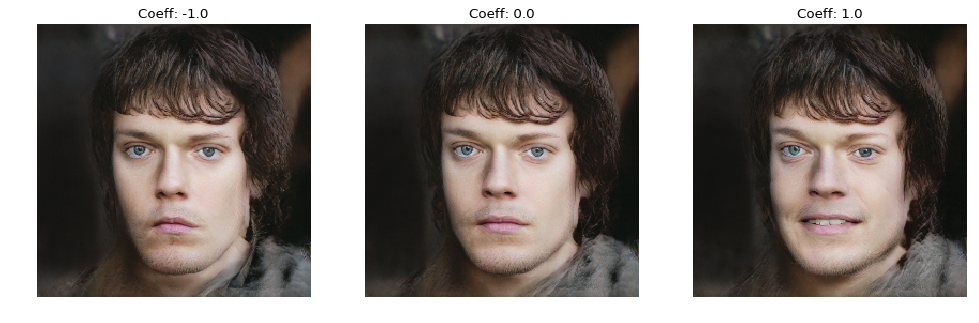

In [0]:
move_and_show(theon, smile_direction, [-1, 0, 1])

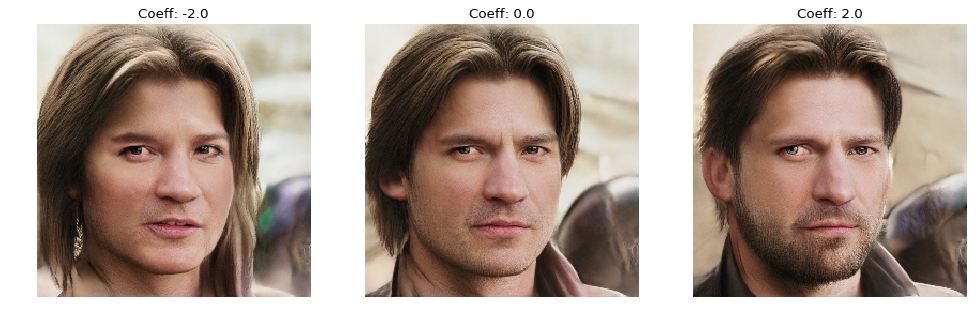

In [0]:
move_and_show(jaime, gender_direction, [-2, 0, 2])

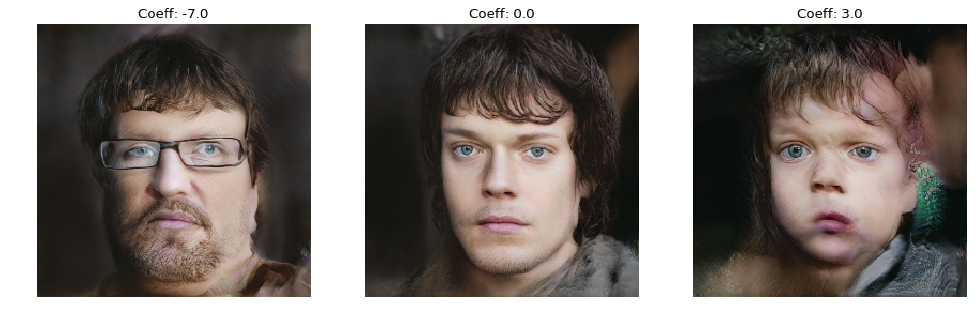

In [0]:
move_and_show(theon, age_direction, [-7, 0, 3])

#Character Fusion

We can also try mixing characters together to find an "average" of the two. The easiest way to do this is to simply take an average of the two latent vectors and generate an image using the average latent vector. You can also adjust how much of each character you want by changing `alpha`.


Now for the moment of truth -- Let's see what the future protector of the realm will look like!

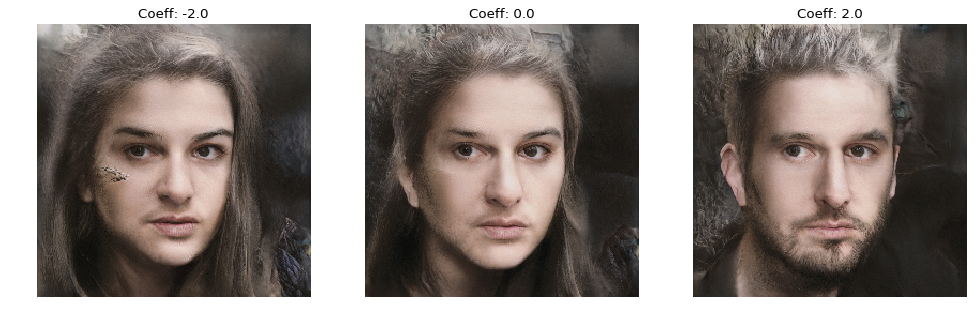

In [0]:
alpha = 0.5

mix = (((alpha)*jon)+((1-alpha)*daenerys))

move_and_show(mix, gender_direction, [-2, 0, 2])

Note that above, you basically created a new character, so can save that latent and do the age, gender, and smile transforms as shown above.

The second, and perhaps more interesting way to fuse characters i through Nvidia's style mixing technique. Refer back to the [main article](https://blog.nanonets.com/stylegan-got/https://blog.nanonets.com/got-gan) to learn how this works. The code below is a modification of Nvidia's style mixing implementation.

In [0]:
def draw_style_mixing_figure(png, Gs, w, h, src_dlatents, dst_dlatents, style_ranges):
    print(png)
    #src_dlatents = Gs.components.mapping.run(src_latents, None) # [seed, layer, component]
    #dst_dlatents = Gs.components.mapping.run(dst_latents, None)
    src_images = Gs.components.synthesis.run(src_dlatents, randomize_noise=False, **synthesis_kwargs)
    dst_images = Gs.components.synthesis.run(dst_dlatents, randomize_noise=False, **synthesis_kwargs)

    canvas = PIL.Image.new('RGB', (w * (len(src_dlatents) + 1), h * (len(dst_dlatents) + 1)), 'white')
    for col, src_image in enumerate(list(src_images)):
        canvas.paste(PIL.Image.fromarray(src_image, 'RGB'), ((col + 1) * w, 0))
    for row, dst_image in enumerate(list(dst_images)):
        canvas.paste(PIL.Image.fromarray(dst_image, 'RGB'), (0, (row + 1) * h))
        row_dlatents = np.stack([dst_dlatents[row]] * len(src_dlatents))
        row_dlatents[:, style_ranges[row]] = src_dlatents[:, style_ranges[row]]
        row_images = Gs.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)
        for col, image in enumerate(list(row_images)):
            canvas.paste(PIL.Image.fromarray(image, 'RGB'), ((col + 1) * w, (row + 1) * h))
    canvas.save(png)
    return canvas.resize((512,512))

results/style-mixing.png


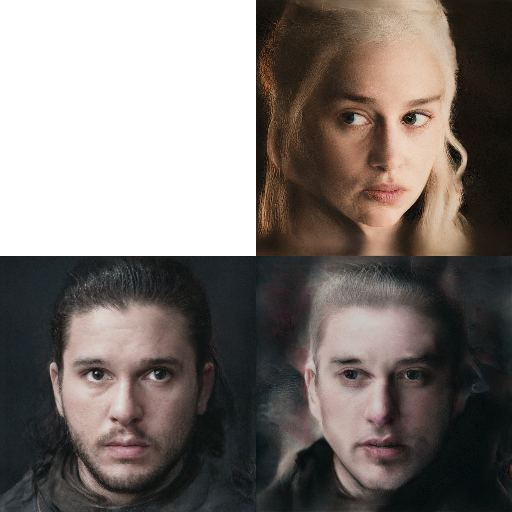

In [0]:
tflib.init_tf()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)
_Gs_cache = dict()

draw_style_mixing_figure(os.path.join(config.result_dir, 'style-mixing.png'), Gs, w=1024, h=1024, src_dlatents=daenerys.reshape((1, 18, 512)), dst_dlatents=jon_2.reshape((1, 18, 512)), style_ranges=[range(6,14)])

Surprisingly, I found the simple averaging method to produce better results, and I'm not sure why that's the case. I'd encourage you to keep trying Nvidia's style mixing method with different paramets, since you might get some really cool results.

# Interpolation Videos


This secion will prduce one of the most exciting reults -- GAN interpolation videos. These videos perform smooth transitions between various images, which you'll only understand if you watch one yourself. So to make your own, start by tweaking these parameters to your preferences (note: this can increase the time it takes to generate a video).

In [0]:
duration_sec = 5.0
smoothing_sec = 1.0
mp4_fps = 20
num_frames = int(np.rint(duration_sec * mp4_fps))

Next, we'll define two helper functions like the ones from the start of this notebook. Except, these will reurn image arrays instead.

In [0]:
def generate_image_for_video(latent_vector):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]

    return img_array
  
  
def move_for_video(latent_vector, direction, coeff):
  
  new_latent_vector = latent_vector.copy()
  new_latent_vector[:8] = (latent_vector + coeff*direction)[:8]
  
  img_array = generate_image(new_latent_vector)
  
  return img_array

Finally, run this code block to generate cool videos. The results will be saved under the reults folder. Follow the comments to generate different kinds of videos, and enjoy!

In [0]:
# If you're interpolating between two characters, set these characters here
char1 = daenerys
char2 = jaime

# This creates an nd array that stores all the image frames fot cross-character interpolation
src_images = np.stack(generate_image_for_video((0.01*alpha*char2)+((1-(0.01*alpha))*char1)) for alpha in range (100))


# Uncomment the next line if you want to do a character transforation video, and choose the arguments as per your requirement
#src_images = np.stack(move_for_video(dany_meme, smile_direction, (0.02*alpha)) for alpha in range (-100,100))


def make_frame(t):
    frame_idx = int(np.clip(np.round(t * mp4_fps), 0, num_frames - 1))
    src_image = src_images[frame_idx]
    return np.array(src_image)

# Generate video.
import moviepy.editor
mp4_file = 'results/interpolate.mp4'
mp4_codec = 'libx264'
mp4_bitrate = '5M'

video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
video_clip.write_videofile(mp4_file, fps=mp4_fps, codec=mp4_codec, bitrate=mp4_bitrate)